#Get the Essential Libraries which are not Pre-Downloaded

In [1]:
!pip install feedparser
!pip install SQLAlchemy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.4 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=8a99aa4a039177d106d4bc32686318cd907668997720c3795687792257496a3d
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


#Importing Libraries for getting the Data

In [2]:
import feedparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importing libaries for creating a Database

In [5]:
from sqlalchemy import create_engine,Column,Integer,String,Float,ForeignKey,DateTime,CHAR,Boolean
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

Base=declarative_base()

#Creating the format of object which will be commited inside the database

In [7]:
class New(Base):
  __tablename__='new_async'
  __table_args__={'extend_existing':True}
  url=Column(String)

  def __init__(self,url):
    self.url=url

  def __repr__(self):
    return f"News('{self.url}')"

class News(Base):
  __tablename__='news'
  __table_args__={'extend_existing':True}
  id=Column(Integer,primary_key=True)
  title=Column(String,primary_key=True)
  description=Column(String)

  def __init__(self,id,title,description):
    self.id=id
    self.title=title
    self.description=description

  def __repr__(self):
    return f"News('{self.id}','{self.title}','{self.description}')"



#Initializing the SQlite Engine and Creating a Session

In [8]:
engine=create_engine('sqlite:///news.db',echo=True)
Base.metadata.create_all(engine)
Session=sessionmaker(bind=engine)
session=Session()

2024-10-10 06:48:17,435 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2024-10-10 06:48:17,453 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("news")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("news")


2024-10-10 06:48:17,462 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2024-10-10 06:48:17,472 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("news")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.table_info("news")


2024-10-10 06:48:17,479 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2024-10-10 06:48:17,488 INFO sqlalchemy.engine.Engine 
CREATE TABLE news (
	id INTEGER NOT NULL, 
	title VARCHAR NOT NULL, 
	description VARCHAR, 
	PRIMARY KEY (id, title)
)




INFO:sqlalchemy.engine.Engine:
CREATE TABLE news (
	id INTEGER NOT NULL, 
	title VARCHAR NOT NULL, 
	description VARCHAR, 
	PRIMARY KEY (id, title)
)




2024-10-10 06:48:17,499 INFO sqlalchemy.engine.Engine [no key 0.01106s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.01106s] ()


2024-10-10 06:48:17,515 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


#Creating a script to pass url and push the news title and Description to the database

In [ ]:
url_list="http://rss.cnn.com/rss/cnn_topstories.rss",
 "http://qz.com/feed",
 "http://feeds.foxnews.com/foxnews/politics",
 "http://feeds.reuters.com/reuters/businessNews",
 "http://feeds.feedburner.com/NewshourWorld",
 "https://feeds.bbci.co.uk/news/world/asia/india/rss.xml"


for url in url_list:
  session.add(New(url))
  session.commit()

In [11]:
def get_data(url_list):
  for file_url in url_list:
    feed=feedparser.parse(file_url)
    for i in range(len(feed.entries)):
      if session.query(News).filter(News.title==feed.entries[i].title).first()==None:
        if 'description' in feed.entries[i]:
          new_news=News(i+1,feed.entries[i].title,feed.entries[i].description)
        else:
          new_news=News(i+1,feed.entries[i].title,np.nan)
        session.add(new_news)
        session.commit()
  return session.query(News).all()

see_data=get_data(session.query(New).all())

#Script to convert the databse object to a Pandas dataframe

In [13]:
data=pd.DataFrame(columns=['title','description'])
for i in range(len(see_data)):
  data.loc[i,'title']=see_data[i].title
  data.loc[i,'description']=see_data[i].description

#import NLTK for text preprocessing and its co and Dependant libraries

In [15]:
# experiment 1 only title
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('nor')
stop_words.remove('against')
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Preprocessing Text


In [16]:
def preprocess(text):
  text=str(text)
  text=re.sub('[^a-zA-Z]',' ',text)
  text=text.lower()
  text=word_tokenize(text)
  text=[word for word in text if not word in stop_words]
  text=[PorterStemmer().stem(word) for word in text]
  text=' '.join(text)
  return text

# Experiment-1
In the First Experiment we are using only the title of the news to predict it into the 4 categories.

In [17]:
data['title']=data['title'].apply(preprocess)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [19]:
X = data['title'].values
vectorizer = TfidfVectorizer()
X_1 = vectorizer.fit_transform(X)

In [20]:
from sklearn.cluster import KMeans

In [22]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_1)

KMeans(n_clusters=4, random_state=42)

In [24]:
data['cluster'] = kmeans.labels_

# View the first few articles and their cluster labels
print(data[['title', 'cluster']].head())

                                               title  cluster
0                                               titl        3
1  air claim dominion vote system fals fox news a...        3
2  dominion still pend lawsuit against elect deni...        3
3  specif fox broadcast tweet dominion say defama...        2
4  judg fox news dominion defam trial parti resol...        3


In [26]:
from sklearn.decomposition import PCA

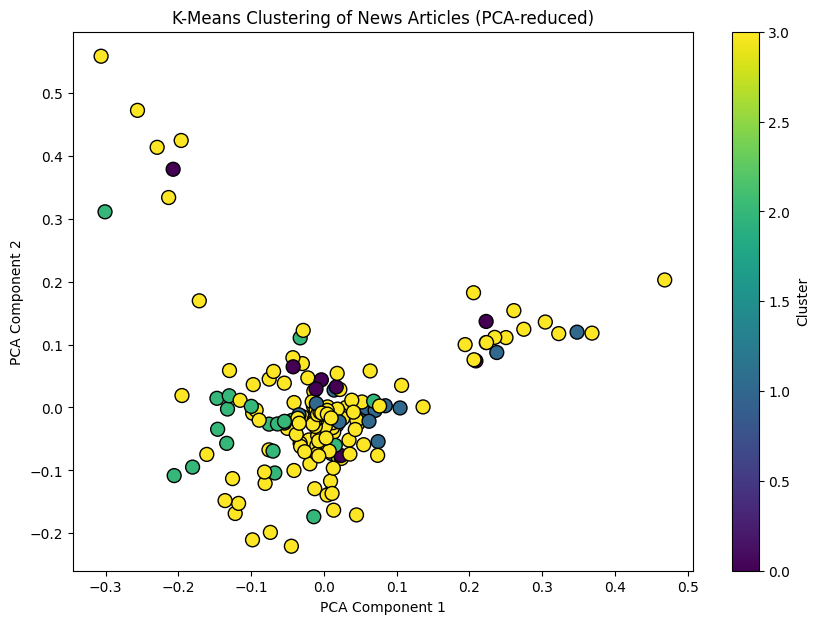

In [28]:
pca = PCA(n_components=2)
X_1_pca = pca.fit_transform(X_1.toarray())

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_1_pca[:, 0], X_1_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('K-Means Clustering of News Articles (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [29]:
data['cluster'].value_counts()

,count
cluster,
3,151
2,20
1,16
0,8


# Experiment-2
In this Experiment we are using Description+Title as the Total data for training

In [30]:
data=pd.DataFrame(columns=['title','description'])
for i in range(len(see_data)):
  data.loc[i,'title']=see_data[i].title
  data.loc[i,'description']=see_data[i].description

In [31]:
data['title']=data['title'].apply(preprocess)
data['description']=data['description'].apply(preprocess)

In [32]:
data['total_data']=data['title']+' '+data['description']

In [38]:
X = data['total_data'].values
vectorizer = TfidfVectorizer()
X= vectorizer.fit_transform(X)

In [43]:
num_clusters = 4  # Set the number of clusters (corresponding to 4 categories)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [44]:
data['cluster'] = kmeans.labels_

# View the first few articles and their cluster labels
print(data[['title', 'cluster']].head())

                                               title  cluster
0                                               titl        3
1  air claim dominion vote system fals fox news a...        3
2  dominion still pend lawsuit against elect deni...        3
3  specif fox broadcast tweet dominion say defama...        3
4  judg fox news dominion defam trial parti resol...        3


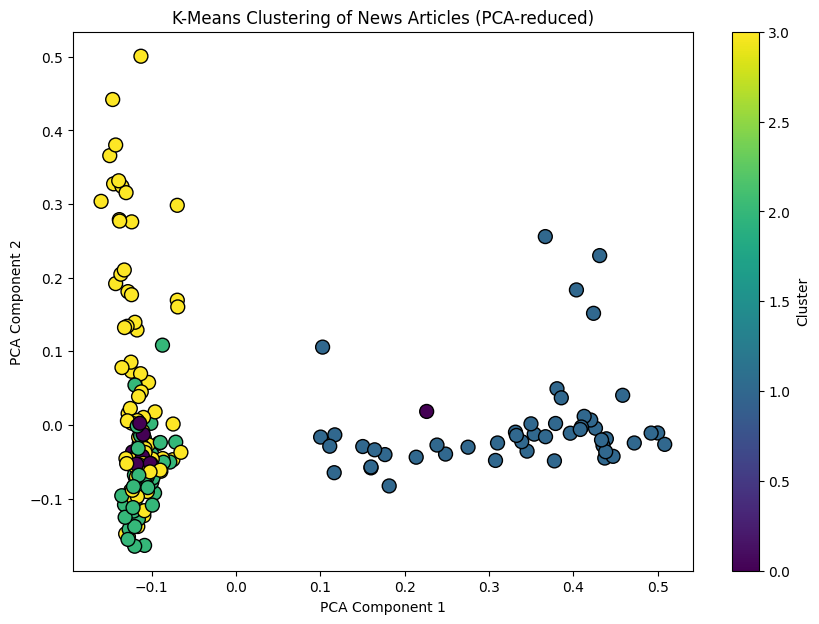

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('K-Means Clustering of News Articles (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [46]:
data['cluster'].value_counts()

,count
cluster,
3,84
1,49
2,48
0,14


# Experiment-3
In this experiment we are using Tensoflow+keras power of RNN's as well as Autoencoders theory of latent space

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.4197 - val_loss: -0.6785
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: -1.4432 - val_loss: -2.9602
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: -4.5199 - val_loss: -8.4527
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: -11.3220 - val_loss: -28.0615
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: -31.5540 - val_loss: -79.8774
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: -88.6895 - val_loss: -150.7910
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: -163.6499 - val_loss: -224.5597
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: -241.8957 - val_loss: -305.8427
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: -338.2957 - val_loss: -400.1201
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: -438.6022 - val_loss: -512.7599
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
                                          total_data  cluster
0                                

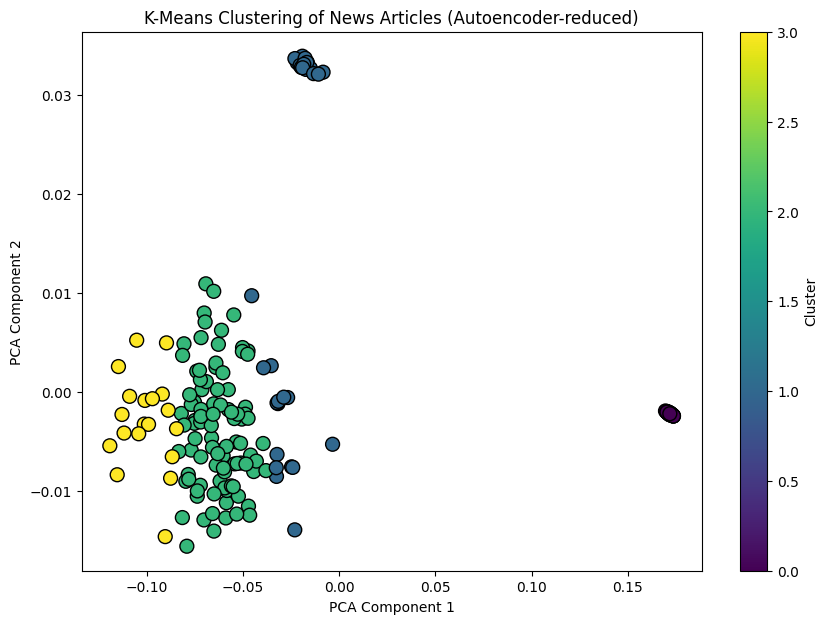

In [49]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess the Data
# Load your dataset (assume there is a 'text' column with news articles) # Replace with your actual file path
texts = data['total_data'].values

# Preprocess text data using Keras Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
X_seq = tokenizer.texts_to_sequences(texts)

# Pad sequences to a fixed length
max_len = 100  # You can adjust this as needed
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Step 2: Define the Autoencoder Model
input_dim = max_len  # Input sequence length
embedding_dim = 64   # Embedding dimension size

# Encoder
input_text = Input(shape=(input_dim,))
embedding_layer = Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_len)(input_text)
encoded = LSTM(64, return_sequences=False)(embedding_layer)  # 64-dimensional compressed representation

# Decoder (optional for reconstruction, not used in clustering)
decoded = Dense(embedding_dim, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_text, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Step 3: Train the Autoencoder
# Train the autoencoder using the padded text data (X_pad)
autoencoder.fit(X_pad, X_pad, epochs=10, batch_size=64, validation_split=0.2)

# Step 4: Extract the Encoder for Feature Extraction
encoder = Model(inputs=input_text, outputs=encoded)

# Get the encoded (compressed) representation of the input data
X_encoded = encoder.predict(X_pad)

# Step 5: Apply K-Means Clustering on the Encoded Features
num_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_encoded)

# Assign cluster labels to the data
data['cluster'] = kmeans.labels_

# Print the first few rows of the data with cluster labels
print(data[['total_data', 'cluster']].head())

# Step 6: Visualize the Clusters using PCA
# Reduce dimensionality to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', edgecolor='k', s=100)
plt.title('K-Means Clustering of News Articles (Autoencoder-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [50]:
data['cluster'].value_counts()

,count
cluster,
2,94
0,50
1,32
3,19
